In [16]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_4DLorenz.recursive_LSTM_PostMeanScore_4DLorenz_T256_H05_tl_110data import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
num_paths = 10952

In [18]:
def get_drift_files(config):
    ts_type = f"{config.ndims}DLnz"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    global_files = []
    true_files = []
    local_files = []
    for file in os.listdir(root_dir):
        print(((f"{config.forcing_const}FConst").replace(".","")))
        if "IIDNadaraya" in file and ts_type in file and include in file and ((f"{config.forcing_const}FConst").replace(".","") in file):
            if "global" in file:
                global_files.append(root_dir+file)
            elif "true" in file:
                true_files.append(root_dir+file)
            elif "local" in file:
                local_files.append(root_dir+file)
    assert len(global_files)>0, "No global files found"
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(global_files) == len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    global_files = sorted(global_files, key=extract_bw_number)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in global_files]
    return global_files, true_files, local_files, bws

In [19]:
config = get_config()
_, true_files, local_files, bws = get_drift_files(config=config)
local_files

125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst
125FConst


['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftTrack_00001bw_10952NPaths_00t0_3906e-03dT_125FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftTrack_0000126bw_10952NPaths_00t0_3906e-03dT_125FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftTrack_0000159bw_10952NPaths_00t0_3906e-03dT_125FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftTrack_0000201bw_10952NPaths_00t0_3906e-03dT_125FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftTrack_0000254bw_10952NPaths_00t0_3906e-03dT_125FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftTrack_0000321bw_10952NPaths_00t0_3906e-03dT_125FConst_l

0.05919764278221272 0.0 inf 0


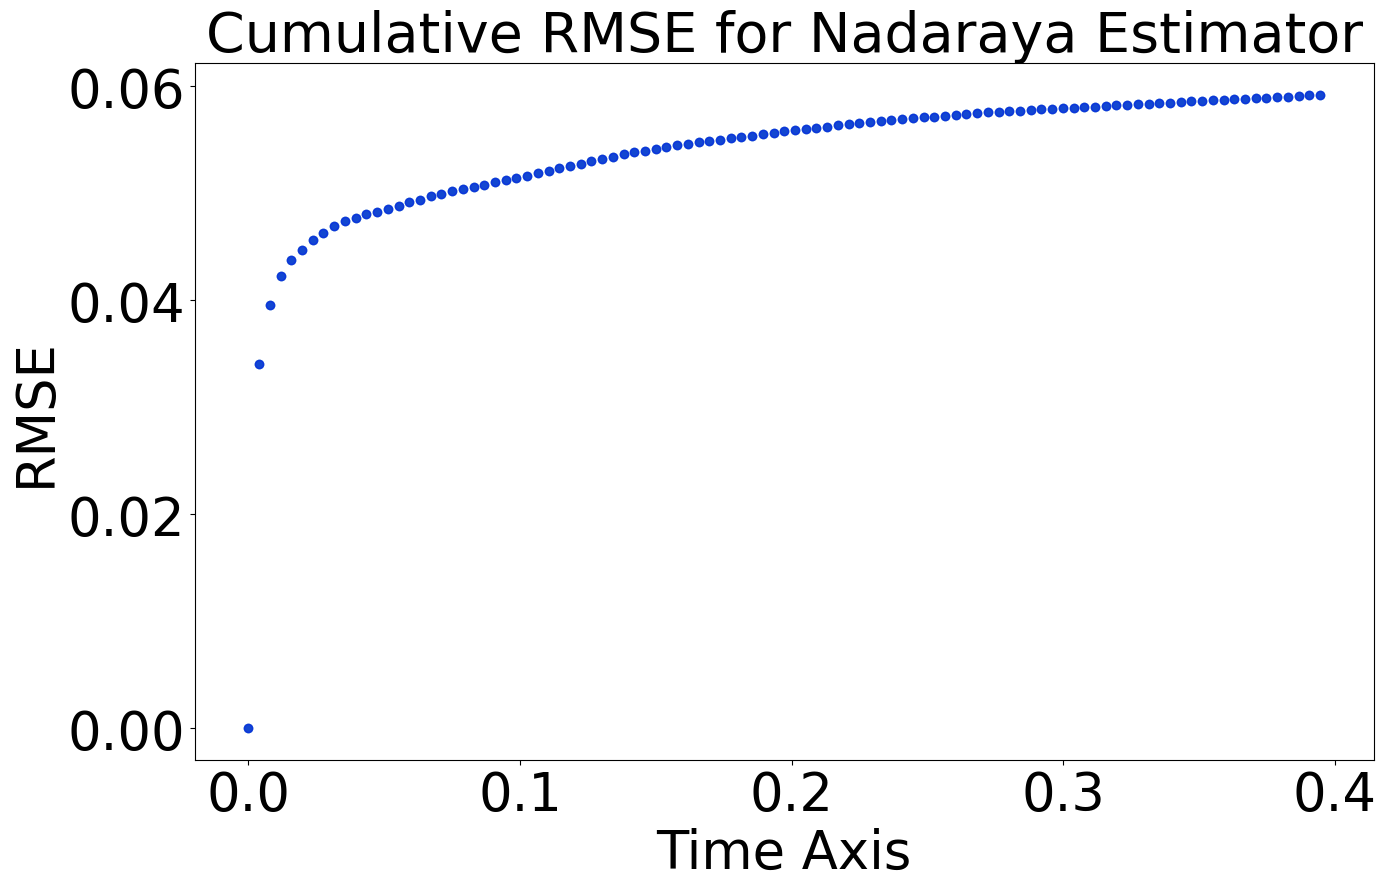

Final time cumulative RMSE local-time error 0.05919764278221272 with IQR ((0.059197642782212706, 0.059197642782212706))at bw 1e-05 for 1.25FConst

0.06016852475067187 0.0 0.05919764278221272 1
0.06016852475067187 0.0 0.05919764278221272 2
0.06050186211254836 0.0 0.05919764278221272 3
0.06070095349523084 0.0 0.05919764278221272 4
0.06332531711547254 0.0 0.05919764278221272 5
0.07472802382111661 0.0 0.05919764278221272 6
0.08080525850037075 0.0 0.05919764278221272 7
0.08462444279933085 0.0 0.05919764278221272 8
0.09528293979233933 0.0 0.05919764278221272 9
0.10696372241872251 0.0 0.05919764278221272 10
0.12345035556969379 0.0 0.05919764278221272 11
0.13801322559247758 0.0 0.05919764278221272 12
0.14937422728552413 0.0 0.05919764278221272 13
0.16306959173231986 0.0 0.05919764278221272 14
0.17564662493103633 0.0 0.05919764278221272 15
0.19184610600715113 0.0 0.05919764278221272 16


In [20]:
curr_rmse = np.inf
toSave = True
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])/np.sqrt(config.deltaT)
    all_local_states = np.load(file[1])/np.sqrt(config.deltaT)
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        total_local_errors_minq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], total_local_errors_maxq[-1]-total_local_errors_minq[-1], curr_rmse, i)
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            miny = total_local_errors-total_local_errors_minq
            miny[miny < 0.] = 0.
            maxy = total_local_errors_maxq-total_local_errors
            maxy[maxy < 0.] = 0.
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
            plt.errorbar(time_steps,total_local_errors,yerr=[miny, maxy],xerr=None, fmt='o', color="blue", alpha=0.4)
            ax.set_title(f"Cumulative RMSE for Nadaraya Estimator",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/IIDNadaraya_4DLnz_DriftTrack_{round(bw, 6)}bw_{config.forcing_const}FConst").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at bw {bw} for {config.forcing_const}FConst\n")